# iminuit: fitting models to data

**Hans Dembinski** | TU Dortmund

**PyPI** https://pypi.org/project/iminuit

**Source** https://github.com/scikit-hep/iminuit

**Documentation** http://iminuit.readthedocs.org

**Latest release** v2.16.0

![](iminuit_logo.svg)

## Introduction

### iminuit is (not only) a frontend to the Minuit2 C++ library

- Minimize statistical cost functions with box constraints
- Compute **parameter uncertainties** under these constraints (unique)
- Robust technology from 1975 that stood the tests of time
- Minuit or Minuit2 are behind virtually every HEP analysis
- iminuit is Python frontend to Minuit2 C++ code in ROOT
    - iminuit contributed several patches to Minuit2 C++
    - For history of Minuit and iminuit, see [PyHEP 2020 talk](https://github.com/hdembinski/pyhep-2020-iminuit)
- Used as backend by many HEP/astroparticle fitting packages (zfit, pyhf, gammapy, ctapipe, ...)
- Common **cost functions** have been added to the library

### iminuit or pyhf or zfit?

- iminuit is low-level, lightweight, hackable, easy to learn, easy to extend
- Supports all kinds of fits: unbinned and binned, templates, penalized, simultaneous
- Simplicity is useful for teaching, attractive for beginners and experts
    - [Glen Cowan](https://inspirehep.net/literature?sort=mostrecent&size=25&page=1&q=f%20a%20g%20cowan%20and%20ac%20%3C%2010) is using iminuit in lectures on statistics
- Out of scope
    - Building statistical models: you need to write the pdf/cdf by hand
    - Automatic differentiation of model
    - Making sophisticated limits
    - Storing likelihoods
- Where the other fitting tools shine
    - [pyhf](https://github.com/scikit-hep/pyhf): Complex binned fits a la HistFactory, limit setting, storing the likelihood
    - [zfit](https://github.com/zfit/zfit): Building statistical models, easy sampling from fitted model

## A simple line fit

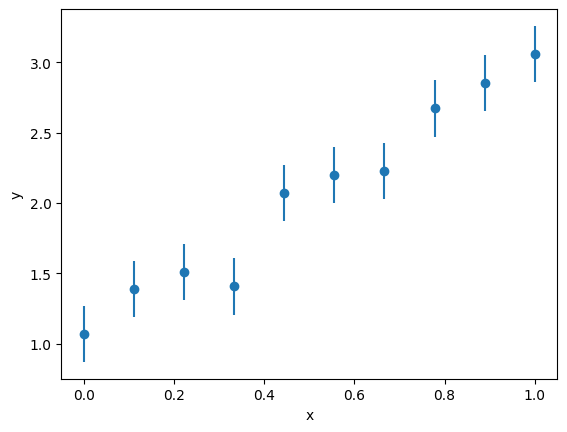

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from argparse import Namespace

# make 10 data points with scatter on y-coordinate

rng = np.random.default_rng(1)

x = np.linspace(0, 1, 10)
ye = np.ones_like(x) * 0.2
y = rng.normal(2 * x + 1, ye)

data = Namespace(x=x, y=y, ye=ye)

# draw that

plt.errorbar(data.x, data.y, data.ye, fmt="o")
plt.xlabel("x")
plt.ylabel("y");

To get parameters of the line:

- Need to provide **model** and **cost function**
- Model predicts $y = f(x; \vec p)$ for some parameters $\vec p$
- Cost function computes some "distance" between model and observations

- No need to write cost function, `iminuit.cost` contains all common ones
- Model can be any vectorized Python function

In [2]:
from iminuit import Minuit, cost

# line model
def model(x, a, b):
    return a + b * x

# see docs for iminuit.cost to pick correct cost function
lsq = cost.LeastSquares(data.x, data.y, data.ye, model)

# - initialize Minuit object by passing cost function
# - Minuit uses a local minimizer, we need to set starting values
m = Minuit(lsq, a=0, b=0)
m

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,a,0.0,0.1,,,,,
1,b,0.0,0.1,,,,,


- iminuit detected that `lsq` has parameters named `a` and `b`
- `Minuit`: stateful fitting object
  - Represents current state of fit
  - Central object to interact with fitting process

In [3]:
# call Migrad minimizer (for other options, see docs)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3.959 (chi2/ndof = 0.5)    │              Nfcn = 34               │
│ EDM = 2.65e-23 (Goal: 0.0002)    │            time = 0.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   1.05    │   0.12    │            │            │         │         │       │
│ 1 │ b    │   1.99    │   0.20    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────┐
│   │       a       b │
├───┼─────────────────┤
│ a │  0.0138 -0.0196 │
│ b │ -0.0196  0.0393 │
└───┴─────────────────┘

- Printed values and errors are rounded to **PDG rounding rules**
- *Hesse error*: standard symmetric error estimate (based on asymptotic theory)
- *Minos error*: standard asymmetric error estimate (based on likelihood profiling)
- *EDM*: estimated distance to minimum, must be smaller than "Goal"; shows that Migrad converged
- *Nfcn*: How many function calls were used by Migrad
- *Pos. def.*: Hessian matrix (matrix of second derivatives) is positive definite; must be for valid minimum
- *chi2/ndof*: Computed at no additional cost whenever possible if iminuit's cost functions are used

See docs for more details on Hesse, Minos, EDM.

Output by parts:

In [4]:
m.params

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,a,1.05,0.12,,,,,
1,b,1.99,0.20,,,,,


In [5]:
m.fmin

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3.959 (chi2/ndof = 0.5)    │              Nfcn = 34               │
│ EDM = 2.65e-23 (Goal: 0.0002)    │            time = 0.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘

In [6]:
m.covariance

,a,b
a,0.0138,-0.0196 (-0.843)
b,-0.0196 (-0.843),0.0393


In [7]:
# Minos Errors are not automatically computed, you need to run *Minos* explicitly
m.minos()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3.959 (chi2/ndof = 0.5)    │              Nfcn = 60               │
│ EDM = 2.65e-23 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   1.05    │   0.12    │   -0.12    │    0.12    │         │         │       │
│ 1 │ b    │   1.99    │   0.20    │   -0.20    │    0.20    │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┐
│          │           a           │           b           │
├──────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │   -0.12   │   0.12    │   -0.2    │    0.2    │
│  Valid   │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┘
┌───┬─────────────────┐
│   │       a       b │
├───┼─────────────────┤
│ a │  0.0138 -0.0196 │
│ b │ -0.0196  0.0393 │
└───┴─────────────────┘

- Hesse and Minos errors identical in this case, because asymptotic theory is correct here
- Prefer reporting Hesse errors unless Minos errors differ a lot

In [8]:
# Minos errors can be read-out like this

me = m.merrors["a"] # returns a data struct with many fields

me.name, me.is_valid, me.lower, me.upper

('a', True, -0.11755076272896135, 0.11755076272914197)

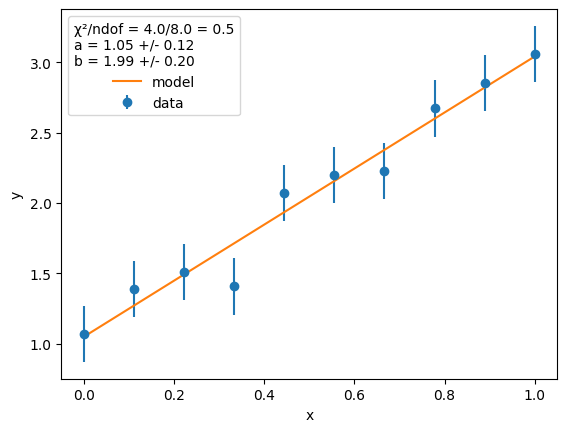

In [9]:
# draw data and fitted model

plt.errorbar(data.x, data.y, data.ye, fmt="o", label="data")
plt.plot(data.x, model(data.x, *m.values[:]), label="model")

# m.fval is only chi2 if cost function supports that
# telltale sign: m.ndof returns something finite and not None
chi2 = m.fval
ndof = m.ndof

title = [
    f"χ²/ndof = {chi2:.1f}/{ndof} = {chi2/ndof:.1f}",
]
for par in m.parameters:
    title.append(
        f"{par} = {m.values[par]:.2f} +/- {m.errors[par]:.2f}"
    )

plt.legend(title="\n".join(title))
plt.xlabel("x")
plt.ylabel("y");

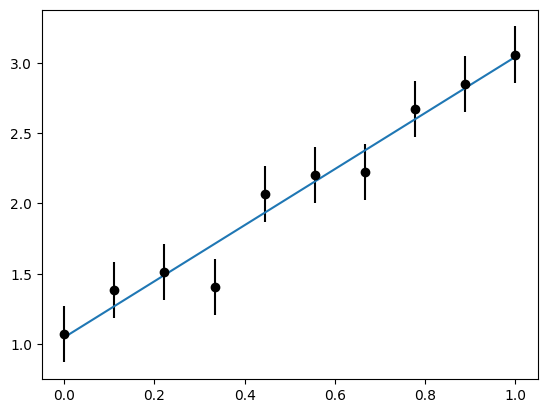

In [10]:
# or use builtin visualization (only for 1D data)
lsq.visualize(m.values)

* Simple plotting of cost function around minimum is provided
* Useful for debugging, if fit fails or looks fishy (we will see examples later)

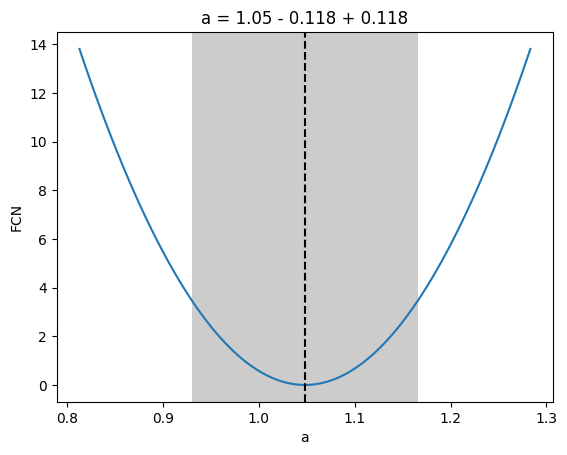

In [11]:
m.draw_profile("a");

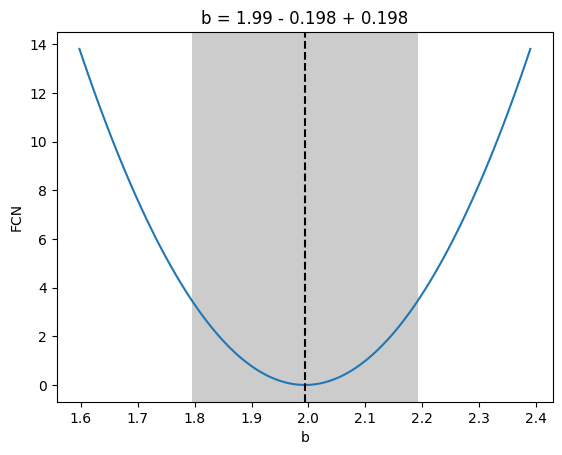

In [12]:
m.draw_profile("b");

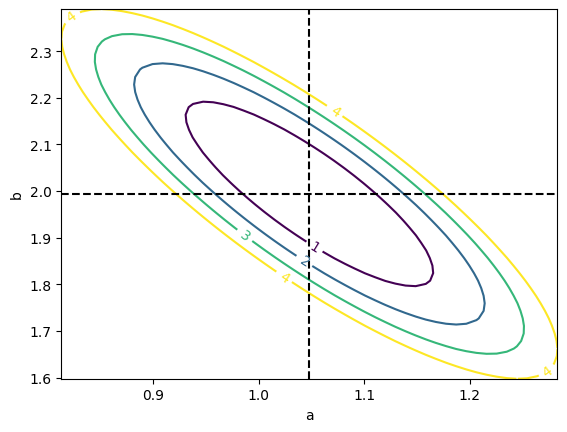

In [13]:
m.draw_contour("a", "b");

* `Minuit.draw_mncontour` draws a 68 % confidence region
* In general, more expensive to compute than `Minuit.draw_contour`

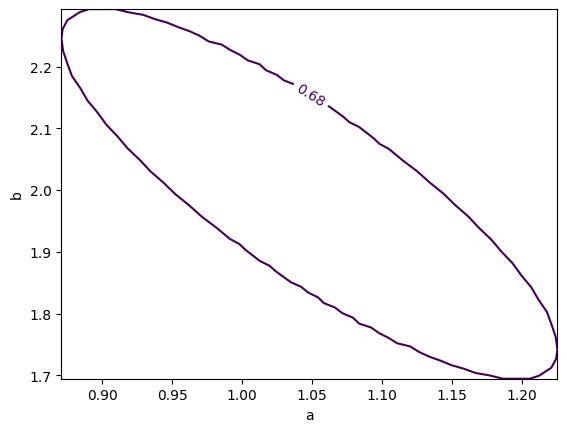

In [14]:
m.draw_mncontour("a", "b");

In [15]:
# tilt of ellipse indicates anti-correlation
m.covariance

,a,b
a,0.0138,-0.0196 (-0.843)
b,-0.0196 (-0.843),0.0393


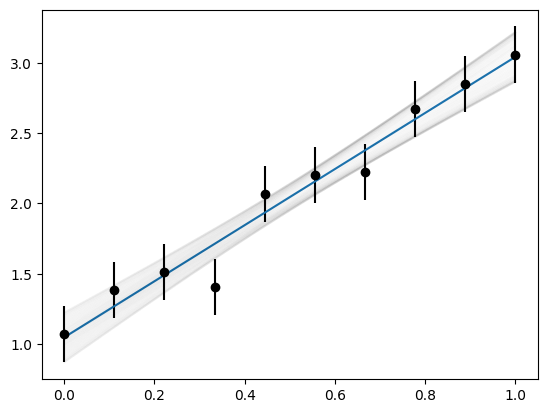

In [16]:
lsq.visualize(m.values)

ab = m.mncontour("a", "b")
for a, b in ab:
    plt.plot(data.x, model(data.x, a, b), color="k", alpha=0.01)

* Don't draw error bands this way, this is just for illustration
* [iminuit docs have a tutorial on how to make error bands](https://iminuit.readthedocs.io/en/stable/notebooks/error_bands.html)
* One way is to use [jacobi](https://github.com/HDembinski/jacobi), another is to use [resample](https://github.com/scikit-hep/resample/)

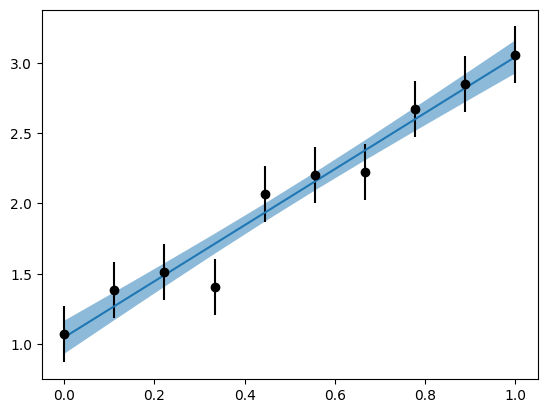

In [17]:
import jacobi

lsq.visualize(m.values)

y, ycov = jacobi.propagate(lambda p: model(x, *p), m.values, m.covariance)
ye = np.diag(ycov) ** 0.5

plt.fill_between(x, y - ye, y + ye, alpha=0.5);

#### **New**: matrix of profiled likelihoods ⚡️

* Handy (but costly) way to inspect the profiled likelihood for all pairs of parameters

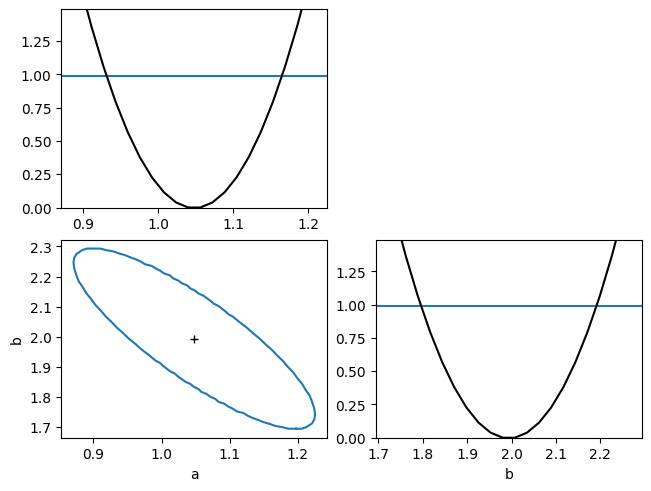

In [18]:
m.draw_mnmatrix();

## Why fits fail and how to fix it

#### Starting values far away

- Fits can fail when starting values are poor
- Numerical reasons
  - Cost function uses log(pdf) and pdf may return 0 when data are far away from prediction
  - Curvature of cost function may become so small that Minuit thinks the fit has converged
    (stopping criterion is based on gradient and curvature)

In [19]:
# numba_stats has faster versions of statistical distributions in scipy.stats 
from numba_stats import norm

rng = np.random.default_rng(1)

x = rng.normal(size=100)

nll = cost.UnbinnedNLL(x, norm.pdf)

# uh oh, starting value for loc far away
m = Minuit(nll, loc=50, scale=1)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.487e+05                  │              Nfcn = 137              │
│ EDM = nan (Goal: 0.0002)         │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ ABOVE EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ loc   │    5e1    │    nan    │            │            │         │         │       │
│ 1 │ scale │     1     │    nan    │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────┐
│       │   loc scale │
├───────┼─────────────┤
│   loc │   nan   nan │
│ scale │   nan   nan │
└───────┴─────────────┘

* Mental note: "Hesse ok" is wrong, a bug in C++ Minuit2!
* If you find things like this, don't 🤷‍♂️, [please report a minimal reproducer in iminuit issues](https://github.com/scikit-hep/iminuit/)
* Also great way to contribute to Hackashop

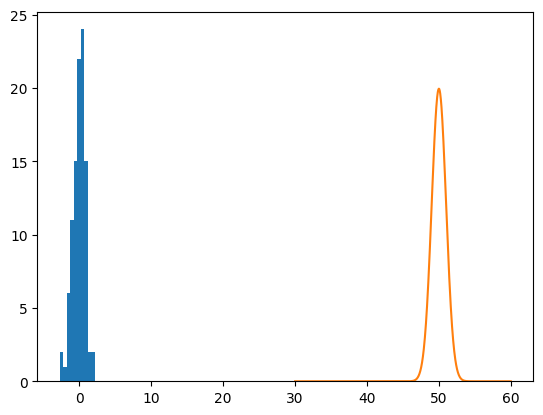

In [20]:
plt.hist(x)
xm = np.linspace(30, 60, 1000)
ym = norm.pdf(xm, *m.values) * 50
plt.plot(xm, ym);

In [21]:
norm.pdf([1, 10, 100, 1000], 0, 1)

array([2.41970725e-01, 7.69459863e-23, 0.00000000e+00, 0.00000000e+00])

* By using a good starting value for `loc` we fix the issue

In [22]:
m = Minuit(nll, loc=0, scale=1)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 251.6                      │              Nfcn = 31               │
│ EDM = 2.2e-05 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ loc   │   -0.07   │   0.09    │            │            │         │         │       │
│ 1 │ scale │   0.85    │   0.06    │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────┐
│       │      loc    scale │
├───────┼───────────────────┤
│   loc │  0.00725 2.67e-06 │
│ scale │ 2.67e-06  0.00362 │
└───────┴───────────────────┘

- How to fix this
  - Find better starting values, e.g. use values from simulation
  - Use least-squares fit followed by maximum-likelihood fit; least-squares is more robust

* This error also appears in more practical situations: fit of a signal+background model

In [23]:
# Generate signal and background mixture

rng = np.random.default_rng(1)

s = rng.normal(0.5, 0.1, size=1000)
b = rng.exponential(0.8, size=2000)
x = np.append(s, b)
x = x[x < 1]

data = Namespace(x=x, range=(0, 1))

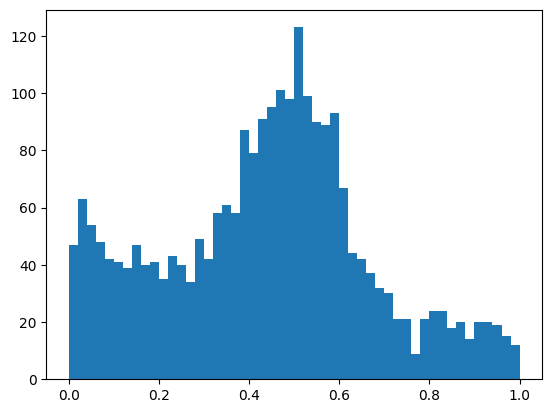

In [24]:
# Bin and draw data

import boost_histogram as bh
# or use numpy.histogram ...

h = bh.Histogram(bh.axis.Regular(50, 0, 1))
h.fill(data.x)

data.edges = h.axes[0].edges
data.n = h.values()

plt.stairs(data.n, data.edges, fill=True);

* Let's do an extended binned fit now

In [25]:
cost.ExtendedBinnedNLL?

In [26]:
from numba_stats import truncnorm, truncexpon

# scaled cdf
def model(x, ns, mu, sigma, nb, slope):
    s = ns * truncnorm.cdf(x, *data.range, mu, sigma)
    b = nb * truncexpon.cdf(x, *data.range, 0, slope)
    return s + b

nll = cost.ExtendedBinnedNLL(data.n, data.edges, model)

m = Minuit(nll, ns=1, mu=5, sigma=0.1, nb=1, slope=1)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = nan                        │              Nfcn = 441              │
│ EDM = nan (Goal: 0.0002)         │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ ABOVE EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ ns    │     1     │    nan    │            │            │         │         │       │
│ 1 │ mu    │     5     │    nan    │            │            │         │         │       │
│ 2 │ sigma │   1e-1    │    nan    │            │            │         │         │       │
│ 3 │ nb    │     1     │    nan    │            │            │         │         │       │
│ 4 │ slope │     1     │    nan    │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────────────────┐
│       │    ns    mu sigma    nb slope │
├───────┼───────────────────────────────┤
│    ns │   nan   nan   nan   nan   nan │
│    mu │   nan   nan   nan   nan   nan │
│ sigma │   nan   nan   nan   nan   nan │
│    nb │   nan   nan   nan   nan   nan │
│ slope │   nan   nan   nan   nan   nan │
└───────┴───────────────────────────────┘

In [27]:
nll(1, 5, 0.1, 1, 1)

nan

#### Model parameters outside mathematical domain

* Minuit can place limits on parameters, this is often necessary
* Examples
  - σ parameter of normal distribution must be positive
  - μ parameter of Poisson distribution must be non-negative
* Without limits on such parameters, fit is likely to fail

In [28]:
m = Minuit(nll, ns=1, mu=0.5, sigma=0.1, nb=1, slope=1)

m.limits["ns", "nb", "sigma", "slope"] = (0, None)
m.limits["mu"] = (0, 1)  # not strictly necessary

m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 203.9 (chi2/ndof = 4.5)    │              Nfcn = 411              │
│ EDM = 1.41e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ ns    │   919.1   │    2.0    │            │            │    0    │         │       │
│ 1 │ mu    │   0.484   │   0.005   │            │            │    0    │    1    │       │
│ 2 │ sigma │   0.094   │   0.004   │            │            │    0    │         │       │
│ 3 │ nb    │ 1.5179e3  │ 0.0020e3  │            │            │    0    │         │       │
│ 4 │ slope │ 1.3171e3  │ 0.0020e3  │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────────────────────────────────────┐
│       │        ns        mu     sigma        nb     slope │
├───────┼───────────────────────────────────────────────────┤
│    ns │      3.99 -5.53e-05  0.000141  -0.00482  1.86e-07 │
│    mu │ -5.53e-05  2.47e-05 -5.01e-06  3.36e-05 -3.24e-08 │
│ sigma │  0.000141 -5.01e-06  1.68e-05 -8.58e-05  1.19e-08 │
│    nb │  -0.00482  3.36e-05 -8.58e-05      3.99 -1.13e-07 │
│ slope │  1.86e-07 -3.24e-08  1.19e-08 -1.13e-07         4 │
└───────┴───────────────────────────────────────────────────┘

* Fit converged but chi2/ndof = 4.5 looks bad, should be around 1

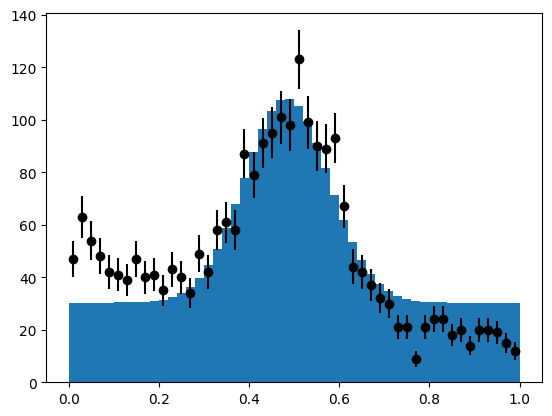

In [29]:
nll.visualize(m.values)

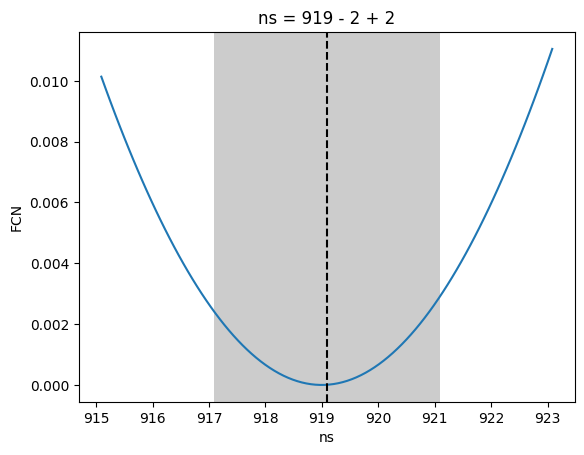

In [30]:
m.draw_profile("ns");

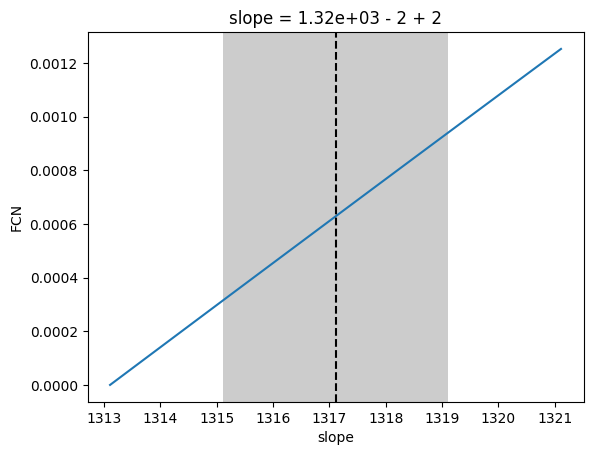

In [31]:
m.draw_profile("slope");

* Fit "converged", although slope is not in a minimum
* Fix this by making limit on slope more tight

In [32]:
m.limits["slope"] = (0, 2)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 40.6 (chi2/ndof = 0.9)     │              Nfcn = 744              │
│ EDM = 3.19e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ ns    │    950    │    50     │            │            │    0    │         │       │
│ 1 │ mu    │   0.498   │   0.005   │            │            │    0    │    1    │       │
│ 2 │ sigma │   0.093   │   0.005   │            │            │    0    │         │       │
│ 3 │ nb    │  1.49e3   │  0.05e3   │            │            │    0    │         │       │
│ 4 │ slope │   0.81    │   0.07    │            │            │    0    │    2    │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────────────────────────────────────┐
│       │        ns        mu     sigma        nb     slope │
├───────┼───────────────────────────────────────────────────┤
│    ns │  2.45e+03   -0.0228     0.108  -1.5e+03    -0.716 │
│    mu │   -0.0228  2.26e-05 -2.86e-06    0.0228 -6.01e-05 │
│ sigma │     0.108 -2.86e-06  2.02e-05    -0.108 -4.48e-05 │
│    nb │  -1.5e+03    0.0228    -0.108  2.99e+03     0.716 │
│ slope │    -0.716 -6.01e-05 -4.48e-05     0.716    0.0045 │
└───────┴───────────────────────────────────────────────────┘

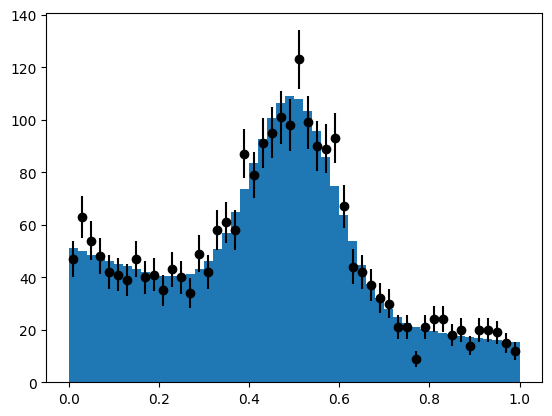

In [33]:
nll.visualize(m.values)

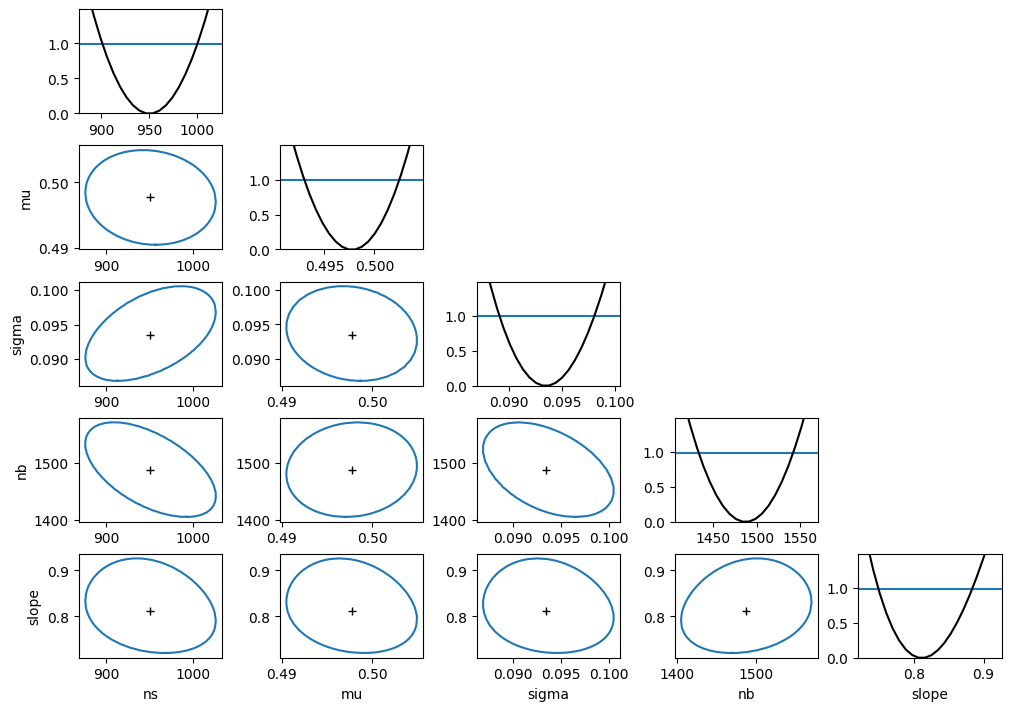

In [34]:
m.draw_mnmatrix(figsize=(10, 7));

#### Model parameters are not constrained by data

- Data may not be precise enough to constrain all model parameters
- Model may be ambiguous, e.g. $f(x) = a + b + c \, x^2$
- Leads to parameters that are perfectly (anti)correlated
- Cannot compute covariance matrix (inverse of Hessian), if Hessian does not have full rank

In [35]:
# add another background component to model to create ambiguity
def model(x, ns, mu, sigma, nb1, slope1, nb2, slope2):
    s = ns * truncnorm.cdf(x, *data.range, mu, sigma)
    b1 = nb1 * truncexpon.cdf(x, *data.range, 0, slope1)
    b2 = nb2 * truncexpon.cdf(x, *data.range, 0, slope2)
    return s + b1 + b2

nll = cost.ExtendedBinnedNLL(data.n, data.edges, model)

m = Minuit(nll, ns=1, mu=0.5, sigma=0.1, nb1=1, slope1=1, nb2=1, slope2=0.1)
m.limits["ns", "nb1", "nb2", "sigma"] = (0, None)
m.limits["mu"] = (0, 1)
m.limits["slope1", "slope2"] = (0, 2)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 694.8 (chi2/ndof = 16.2)   │             Nfcn = 1118              │
│ EDM = 3.37e-10 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │   Hesse FAILED   │APPROXIMATE│NOT pos. def.│ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ ns     │ 4.8263e-9 │ 0.0000e-9 │            │            │    0    │         │       │
│ 1 │ mu     │ 8.5436e-1 │ 0.0000e-1 │            │            │    0    │    1    │       │
│ 2 │ sigma  │ 1.8477e5  │ 0.0000e5  │            │            │    0    │         │       │
│ 3 │ nb1    │ 7.7481e2  │ 0.0000e2  │            │            │    0    │         │       │
│ 4 │ slope1 │  1.3316   │  0.0000   │            │            │    0    │    2    │       │
│ 5 │ nb2    │ 1.6622e3  │ 0.0000e3  │            │            │    0    │         │       │
│ 6 │ slope2 │  1.3317   │  0.0000   │            │            │    0    │    2    │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

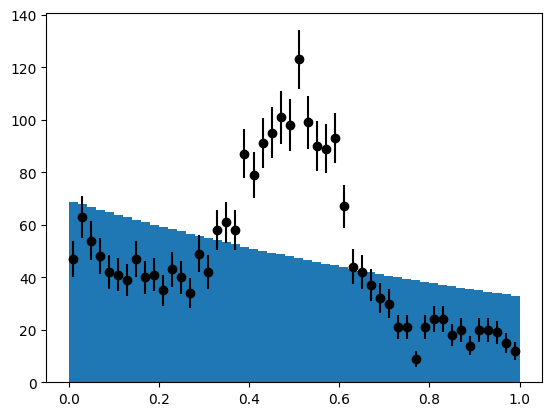

In [36]:
nll.visualize(m.values)

In [37]:
# resolve ambiguity by fixing nb2 to 0... but forget to fix slope2, too
m.values = [p.value for p in m.init_params]
m.values["nb2"] = 0
m.fixed["nb2"] = True
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 40.6 (chi2/ndof = 0.9)     │             Nfcn = 1808              │
│ EDM = 3.68e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │   Hesse FAILED   │APPROXIMATE│NOT pos. def.│ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ ns     │ 9.5004e2  │ 0.0000e2  │            │            │    0    │         │       │
│ 1 │ mu     │ 4.9776e-1 │ 0.0000e-1 │            │            │    0    │    1    │       │
│ 2 │ sigma  │ 9.3454e-2 │ 0.0000e-2 │            │            │    0    │         │       │
│ 3 │ nb1    │  1.487e3  │  0.000e3  │            │            │    0    │         │       │
│ 4 │ slope1 │ 8.1152e-1 │ 0.0000e-1 │            │            │    0    │    2    │       │
│ 5 │ nb2    │     0     │     0     │            │            │    0    │         │  yes  │
│ 6 │ slope2 │   1e-1    │   0e-1    │            │            │    0    │    2    │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

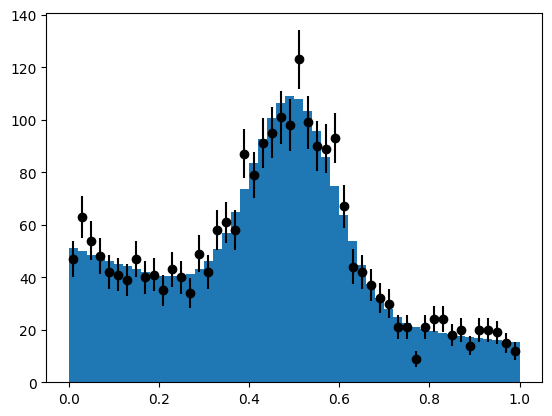

In [38]:
nll.visualize(m.values)

* Fit converged (we were lucky), but errors are wrong since Hesse failed
* `slope2` not constrained by data now, since `nb2 = 0`
* Fixing `slope2` resolve the issue

In [39]:

m.values = [p.value for p in m.init_params]
m.fixed["slope2"] = True
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 40.56 (chi2/ndof = 0.9)    │             Nfcn = 2136              │
│ EDM = 2.02e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ ns     │    950    │    50     │            │            │    0    │         │       │
│ 1 │ mu     │   0.498   │   0.005   │            │            │    0    │    1    │       │
│ 2 │ sigma  │   0.093   │   0.005   │            │            │    0    │         │       │
│ 3 │ nb1    │  1.49e3   │  0.05e3   │            │            │    0    │         │       │
│ 4 │ slope1 │   0.81    │   0.07    │            │            │    0    │    2    │       │
│ 5 │ nb2    │     1     │     0     │            │            │    0    │         │  yes  │
│ 6 │ slope2 │   1e-1    │   0e-1    │            │            │    0    │    2    │  yes  │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────────────────────┐
│        │        ns        mu     sigma       nb1    slope1       nb2    slope2 │
├────────┼───────────────────────────────────────────────────────────────────────┤
│     ns │  2.45e+03   -0.0228     0.108  -1.5e+03    -0.716         0         0 │
│     mu │   -0.0228  2.26e-05 -2.87e-06    0.0229 -6.05e-05         0         0 │
│  sigma │     0.108 -2.87e-06  2.02e-05    -0.108 -4.48e-05         0         0 │
│    nb1 │  -1.5e+03    0.0229    -0.108  2.99e+03     0.715         0         0 │
│ slope1 │    -0.716 -6.05e-05 -4.48e-05     0.715   0.00454         0         0 │
│    nb2 │         0         0         0         0         0         0         0 │
│ slope2 │         0         0         0         0         0         0         0 │
└────────┴───────────────────────────────────────────────────────────────────────┘

* Another practical example: fit signal+background model to background-only sample
* Common in limit setting to compute distribution of test statistic under null hypothesis

In [40]:
def model(x, ns, mu, sigma, nb, slope):
    s = ns * truncnorm.cdf(x, *data.range, mu, sigma)
    b = nb * truncexpon.cdf(x, *data.range, 0, slope)
    return s + b

b = rng.exponential(1, size=2000)
b = b[b < 1]

data.nb = np.histogram(b, bins=data.edges)[0]

nll = cost.ExtendedBinnedNLL(data.nb, data.edges, model)

m = Minuit(nll, ns=10, mu=0.5, sigma=0.1, nb=200, slope=1)
m.limits["ns", "nb", "sigma"] = (0, None)
m.limits["mu"] = (0, 1)
m.limits["slope"] = (0, 2)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 33.56 (chi2/ndof = 0.7)    │              Nfcn = 679              │
│ EDM = 9.4e-05 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ ns    │   0.1e3   │   0.5e3   │            │            │    0    │         │       │
│ 1 │ mu    │   0.75    │   0.18    │            │            │    0    │    1    │       │
│ 2 │ sigma │    0.3    │    0.6    │            │            │    0    │         │       │
│ 3 │ nb    │   1.1e3   │   0.6e3   │            │            │    0    │         │       │
│ 4 │ slope │    0.8    │    0.7    │            │            │    0    │    2    │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────────────────────────────────────┐
│       │        ns        mu     sigma        nb     slope │
├───────┼───────────────────────────────────────────────────┤
│    ns │  3.58e+05       -49       410 -3.58e+05      -472 │
│    mu │       -49    0.0345   -0.0517        49    0.0553 │
│ sigma │       410   -0.0517     0.518      -410    -0.521 │
│    nb │ -3.58e+05        49      -410  3.59e+05       472 │
│ slope │      -472    0.0553    -0.521       472      0.64 │
└───────┴───────────────────────────────────────────────────┘

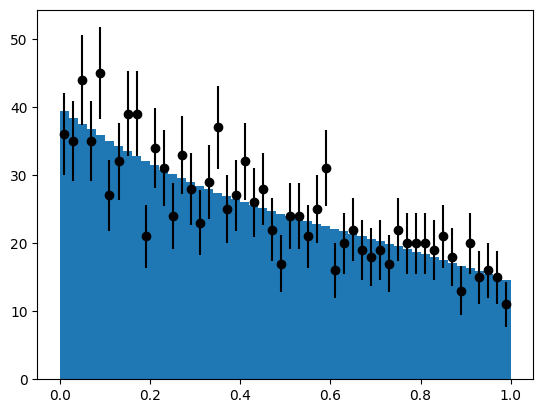

In [41]:
nll.visualize(m.values)

* Fit converged and looks ok (we are lucky), but is very unstable
* Several parameters are almost perfectly correlated, Hessian does not have full rank
* Fix this by adding Gaussian penalty terms for `mu` and `sigma`
* Penalty terms add external pulls when data does not

In [42]:
nll_mod = nll + cost.NormalConstraint(("mu", "sigma"), (0.5, 0.1), (0.1, 0.05))

m = Minuit(nll_mod, ns=1, mu=0.5, sigma=0.1, nb=1, slope=1)
m.limits["ns", "nb", "sigma"] = (0, None)
m.limits["mu"] = (0, 1)
m.limits["slope"] = (0, 2)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 33.89 (chi2/ndof = 0.7)    │              Nfcn = 732              │
│ EDM = 6.68e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ ns    │     0     │    15     │            │            │    0    │         │       │
│ 1 │ mu    │    0.5    │    0.1    │            │            │    0    │    1    │       │
│ 2 │ sigma │   0.10    │   0.05    │            │            │    0    │         │       │
│ 3 │ nb    │  1.255e3  │  0.035e3  │            │            │    0    │         │       │
│ 4 │ slope │   1.06    │   0.11    │            │            │    0    │    2    │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────────────────────────────────────┐
│       │        ns        mu     sigma        nb     slope │
├───────┼───────────────────────────────────────────────────┤
│    ns │     0.217 -0.000413  0.000106    -0.396 -0.000339 │
│    mu │ -0.000413      0.01 -1.83e-07  0.000752  5.96e-07 │
│ sigma │  0.000106 -1.83e-07    0.0025 -0.000193 -1.65e-07 │
│    nb │    -0.396  0.000752 -0.000193  1.26e+03  0.000617 │
│ slope │ -0.000339  5.96e-07 -1.65e-07  0.000617    0.0126 │
└───────┴───────────────────────────────────────────────────┘

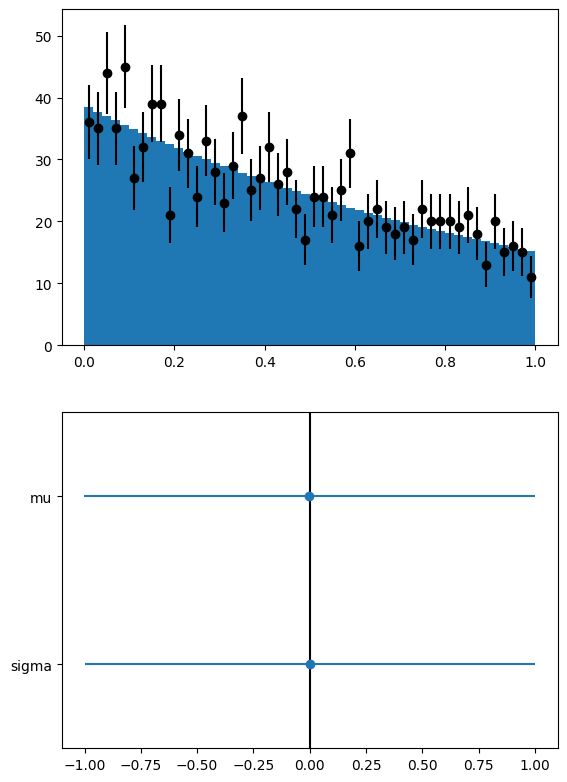

In [43]:
nll_mod.visualize(m.values)

* Correlations are now tamed, Hessian does have full rank, and fit is stable
* Make sure that penalty is weak if data actually constrains model

### Be careful about warning "Parameter at limit"

* Perfectly fine when fitting signal+background model to background-only
  * True value of `ns` is 0, so fitted value may be close to lower limit
* In general: keep limits loose enough so that they do not interfere with error calculation

In [44]:
def model(x, ns, mu, sigma, nb, slope):
    s = ns * truncnorm.cdf(x, *data.range, mu, sigma)
    b = nb * truncexpon.cdf(x, *data.range, 0, slope)
    return s + b

nll = cost.ExtendedBinnedNLL(data.n, data.edges, model)

m1 = Minuit(nll, ns=1000, mu=0.5, sigma=0.1, nb=1000, slope=1)
m1.limits["ns", "nb", "sigma"] = (0, None)
m1.limits["mu"] = (0, 1)
m1.limits["slope"] = (0, 2)
m1.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 40.6 (chi2/ndof = 0.9)     │              Nfcn = 144              │
│ EDM = 6.35e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ ns    │    950    │    50     │            │            │    0    │         │       │
│ 1 │ mu    │   0.498   │   0.005   │            │            │    0    │    1    │       │
│ 2 │ sigma │   0.093   │   0.005   │            │            │    0    │         │       │
│ 3 │ nb    │  1.49e3   │  0.05e3   │            │            │    0    │         │       │
│ 4 │ slope │   0.81    │   0.07    │            │            │    0    │    2    │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────────────────────────────────────┐
│       │        ns        mu     sigma        nb     slope │
├───────┼───────────────────────────────────────────────────┤
│    ns │  2.45e+03   -0.0228     0.108  -1.5e+03    -0.716 │
│    mu │   -0.0228  2.26e-05 -2.86e-06    0.0228 -6.01e-05 │
│ sigma │     0.108 -2.86e-06  2.02e-05    -0.108 -4.48e-05 │
│    nb │  -1.5e+03    0.0228    -0.108  2.98e+03     0.716 │
│ slope │    -0.716 -6.01e-05 -4.48e-05     0.716   0.00449 │
└───────┴───────────────────────────────────────────────────┘

In [45]:
m2 = Minuit(nll, ns=1000, mu=0.5, sigma=0.1, nb=1000, slope=1)
m2.limits["ns", "nb"] = (0, None)
# set tight limits around previously fitted value of sigma
m2.limits["sigma"] = m1.values["sigma"] - 1e-3, m1.values["sigma"] + 1e-3
m2.limits["mu"] = (0, 1)
m2.limits["slope"] = (0, 2)
m2.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 40.65 (chi2/ndof = 0.9)    │              Nfcn = 141              │
│ EDM = 2.11e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ ns    │   955.5   │    1.8    │            │            │    0    │         │       │
│ 1 │ mu    │   0.498   │   0.005   │            │            │    0    │    1    │       │
│ 2 │ sigma │  0.0945   │  0.0017   │            │            │0.0924765│0.0944765│       │
│ 3 │ nb    │ 1.4815e3  │ 0.0018e3  │            │            │    0    │         │       │
│ 4 │ slope │   0.81    │   0.06    │            │            │    0    │    2    │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────────────────────────────────────┐
│       │        ns        mu     sigma        nb     slope │
├───────┼───────────────────────────────────────────────────┤
│    ns │      3.33 -1.02e-05  4.54e-11  -0.00281 -0.000644 │
│    mu │ -1.02e-05  2.24e-05 -7.37e-13  6.55e-06 -6.95e-05 │
│ sigma │  4.54e-11 -7.37e-13  1.97e-13 -2.93e-11 -3.28e-12 │
│    nb │  -0.00281  6.55e-06 -2.93e-11      3.33  0.000416 │
│ slope │ -0.000644 -6.95e-05 -3.28e-12  0.000416   0.00422 │
└───────┴───────────────────────────────────────────────────┘

* Minuit now warns about "Some parameters at limit"
* Fit got slightly worse (FCN 40.65 > 40.6) and error of `sigma` is now too small
* But also errors of other parameters, especially `ns`, are artificially reduced 🙁
* Do not blindly trust Hesse errors when some parameters are at limit

## **New**: Interactive fitting ⚡️

* [ipywidgets](https://ipywidgets.readthedocs.io/en/latest/index.html) package allows one to generate interactive widgets inside Jupyter
  * `ipywidgets.interact` offers an easy way to visualize how a function reacts to parameter changes
* iminuit offers a similar feature to enable an interactive fitting

Useful
* To understand what is going on
* To find starting values
* For teaching

In [46]:
m1.interactive()

## **New**: Template fits ⚡️

* We often fit signal+background mixtures
* Sometimes you do not have a parametric model for signal or background
* If simulation is trustworthy, can generate templates for signal or background from simulation
* But simulation sample is finite, need to include that uncertainty!

* [Barlow, Beeston, Comput.Phys.Commun. 77 (1993) 219-228](https://inspirehep.net/literature/35053)
  * Exact likelihood for this problem
  * Somewhat expensive solve exact likelihood
  * Very limited support for weighted simulation
  * [TFractionFitter in ROOT](https://root.cern.ch/doc/master/classTFractionFitter.html)

* [C.A. Argüelles, A. Schneider, T. Yuan, JHEP 06 (2019) 030, arXiv:1901.04645 [physics.data-an]](https://inspirehep.net/literature/1713790)
  * Alternative Bayesian approach
  * Full support for weighted simulation
  * Faster fits that with TFractionFitter


* [H.P. Dembinski, A. Abdelmotteleb, arXiv:2206.12346, submitted to JHEP](https://arxiv.org/abs/2206.12346)
  * Fast approximation to exact likelihood
  * Full support for weighted simulation and data

In [47]:
cost.BarlowBeestonLite?

In [48]:
rng = np.random.default_rng(1)

# generate templates from "simulation"
nb = np.histogram(rng.normal(0.5, 0.1, size=1000), bins=data.edges)[0]
ns = np.histogram(rng.exponential(1, size=1000), bins=data.edges)[0]

nll = cost.BarlowBeestonLite(data.n,  data.edges, (nb, ns), name=("ns", "nb"))

m = Minuit(nll, ns=1, nb=1)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 31.92 (chi2/ndof = 0.7)    │              Nfcn = 113              │
│ EDM = 1.8e-06 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ ns   │    990    │    70     │            │            │         │         │       │
│ 1 │ nb   │  1.45e3   │  0.09e3   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────┐
│    │        ns        nb │
├────┼─────────────────────┤
│ ns │  4.58e+03 -2.62e+03 │
│ nb │ -2.62e+03  7.47e+03 │
└────┴─────────────────────┘

* Error on `ns` larger compared to fitting parametric model (70 vs 50), since uncertainty of template not negligible 

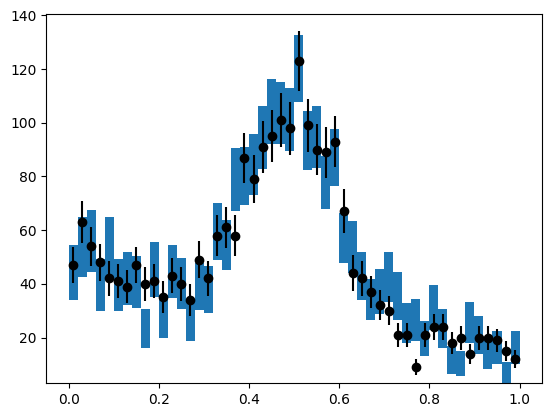

In [49]:
nll.visualize(m.values)

In [50]:
m.interactive()

* `BarlowBeestonLite` also supports higher dimensional data (2D, 3D, ...)
* Weighted data and weighted simulation are supported
* chi2/ndof is computed automatically
* Performance comparable to exact Barlow-Beeston method

* Warning: still need to estimate systematic uncertainties of simulation deviating from data
* No automatic way in iminuit or elsewhere to handle this

## Want to learn more?

* iminuit's comprehensive docs are full of [tutorials](https://iminuit.readthedocs.io/en/stable/tutorials.html) and [practical studies around fitting](https://iminuit.readthedocs.io/en/stable/studies.html)